

Per il coach che correggera' questo progetto:

1. Il progetto viene mostrato seguendo la pipeline standard, dall'import alla discussione finale. Ho inserito alcuni capitoli iniziali con delle funzioni costruite da me. Ognuna ha un'accurata documentazione. In particolare:

- (-1): contiene installazioni ed imports necessari;

- (A): contiene la definizione delle funzioni utili a comprendere le proprieta' di un modello e del suo allenamento;

- (B): contiene le funzioni necessarie a visualizzare le immagini;

2. Ho impostato il notebook in modo estremamente didattico, con spiegazioni dettagliate di ogni passaggio (probabilmente spiegazioni ridondanti, ma meglio abbondare in questo contesto).

3. L'approccio metodologico confronta vari modelli (sempre supportati da data augmentation), alcuni usando trasnfer learning e fine-tuning, alcuni con architetture custom. **NB** dopo vari tentativi, ho notato che l'optimizer migliore e' Adam. Inoltre, non ho utilizzato K-fold cross-validation (come sarebbe giusto) per motivi di tempo e disponibilita' di risorse di calcolo (nel notebook spieghero' meglio questo punto). Quindi, i parametri migliori (architettura, regolarizzazione, learning rate) sono stati scelti facendo svariate prove con cross-validation standard (cioe' usando dapprima i train-validation sets e solo alla fine il test set).

4. Sono consapevole che le funzioni scritte manualmente da me potrebbero essere rese molto piu' robuste (controlli sugli input, type hints, eccetera), ma ho comunque messo documentazione tramite docstring. Per tenere il progetto autoconsistente ma senza esagerare, ho usato definizioni funzionali al contesto e che possono essere riutilizzate in molti altri contesti;

5. Il notebook è stato sviluppato in modo da poter essere rieseguito integralmente dall’inizio senza errori o dipendenze esterne, ed inoltre i risultati sono (il piu' possibile) riproducibili.

6. **Non ho copiato nessun codice**, usando solo la reference ufficiale di TensorFlow.


Chiedo al coach una valutazione il piu' possibile severa. Se fosse possibile, gradirei sapere la votazione, per poter tenere traccia delle mie skills in futuro.

# (-1) Imports and reproducibility

In [ ]:
# basic imports
import os

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold

from tensorflow.keras.backend import clear_session
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import densenet, DenseNet121
from tensorflow.keras.applications import mobilenet_v2, MobileNetV2
from tensorflow.keras.applications import efficientnet, EfficientNetB0
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.applications import vgg16, VGG16
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model


# utils
from tqdm import tqdm
from IPython.display import display

In [ ]:
# warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# reproducibility
import random
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# (A) Training and Testing Results tools

In [ ]:
def plot_learning_curves(training_history, size = (12, 4)):
  """
  training_history: an object of the type training_history = model.fit();
  """

  effective_epochs = len(training_history.history['loss'])

  fig, axes = plt.subplots(1, 2, figsize = size)

  axes[0].plot(range(1, effective_epochs + 1), training_history.history['loss'], label = "Train loss", c = "blue")
  axes[0].plot(range(1, effective_epochs + 1), training_history.history['val_loss'], label = "Test loss", c = "red")
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  axes[0].legend()

  axes[1].plot(range(1, effective_epochs + 1), training_history.history['accuracy'], label = "Train accuracy", c = "blue")
  axes[1].plot(range(1, effective_epochs + 1), training_history.history['val_accuracy'], label = "Test accuracy", c = "red")
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Accuracy")
  axes[1].legend()

  plt.legend()
  plt.tight_layout()
  plt.show()
  plt.close()

In [ ]:
def plot_confusion_matrix(cm = None, split = None, size = (12,5)):

  """
  cm: confusion matrix coming from the method confusion_matrix() of scikit-learn.
  """

  df_cm = pd.DataFrame(cm)
  plt.figure(figsize = size)
  color = "Blues" if split == "Train" else "Reds"
  sns.heatmap(df_cm, cmap = color, annot = True, annot_kws = {'size': 13})
  if split:
    plt.title(f"Confusion Matrix - {split} Set")
  plt.show()
  plt.close()

In [ ]:
def metrics_report(model, X, y, split = "Train", size = (12,5), verbose = False):

  """
  model: a Keras model.
  verbose: if True, the function prints a summary of the standard metrics of a classification problem.
  """

  y = np.array(y)
  logits = model.predict(X)
  yhat = np.argmax(logits, axis = 1)

  metrics_list = ["Accuracy", "F1-score", "Precision", "Recall"]

  # metrics

  accuracy = accuracy_score(y, yhat)
  f1 = f1_score(y, yhat, average = 'macro')
  precision = precision_score(y, yhat, average = 'macro')
  recall = recall_score(y, yhat, average = 'macro')

  # visualization

  metrics = [accuracy, f1, precision, recall]
  metrics_df = pd.DataFrame([metrics], columns = metrics_list, index = [split])

  cm = confusion_matrix(y, yhat)

  if verbose:
    display(metrics_df)
    plot_confusion_matrix(cm, split, size = size)

  return metrics,  metrics_df, cm

# (B) Image Visualization tools

In [ ]:
def before_preprocessing(X, mean = None, std = None):
  """
  function to invert the pre-processing normalization;
  X: (W, H, C) where colors are in BGR format;
  mean and std: must be given in BGR format.
  return: RGB for plotting with pixels in [0, 1.0] range.
  """
  number_of_channels = X.shape[0]

  if mean == None:
    mean = [0] * number_of_channels
  if std == None:
    std = [1] * number_of_channels

  mean = np.array(mean)
  std = np.array(std)

  mean_np = mean.reshape((1, 1, number_of_channels))
  std_np = std.reshape((1, 1, number_of_channels))
  x = np.array(X)

  x = std_np * x + mean_np
  x = np.clip(x, 0, 255.0) # x can contain negative values near to 0
                           # or greater than 255
  x = x/255
  return x[:, :, ::-1] # the return is RGB

In [ ]:
def show_image(X, size = (2, 2)):
  '''
  X: numpy array with shape (W, H, C) and values within [0, 1.0]
  size = (2, 2)
  '''
  plt.figure(figsize = size)
  plt.imshow(X)
  plt.axis('off')
  plt.show()
  plt.close()

In [ ]:
def show_predictions(model, generator, mean = None, std = None, int_to_labels = {},
                     num_images = 8, num_columns = 4, size = (2, 2)):
  """
  int_to_labels: a dictionary in the form {integer : 'label'}
  """
  processed_images, y = next(generator)
  batch_size = processed_images.shape[0]
  if num_images > batch_size:
    num_images = batch_size


  logitshat = model(processed_images)
  yhat = np.argmax(logitshat, dim = 1)

  num_rows = int(num_images/num_columns if num_images%num_columns == 0 else num_images//num_columns + 1)

  fig = plt.figure(figsize = size)

  for index in range(num_images):
    true_label = y[index].item()
    predicted_label = yhat[index].item()
    if int_to_labels != {}:
      true_label = int_to_labels[true_label]
      predicted_label = int_to_labels[predicted_label]
    plt.subplot(num_rows, num_columns , index + 1)
    img_before_preprocessing = before_preprocessing(processed_images[index],
                                                    mean = mean, std = std)
    plt.imshow(img_before_preprocessing.transpose(1, 2, 0))
    plt.axis('off')
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label} | Predicted: {predicted_label}",
              c = color, fontsize = 10)
    plt.tight_layout()
  plt.show()
  plt.close()

# Vehicles and Animals

## Dataset Exploration

Lo step zero consiste nello scaricare il dataset:

In [ ]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape # np array with shape (50000, 32, 32, 3)
y_train.shape # np array with shape (50000, 1)
X_test.shape # np array with shape (10000, 32, 32, 3)
y_test.shape # np array with shape (10000, 1)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
int_to_labels = {i:label for i,label in enumerate(labels)}
labels_to_int = {label:i for i,label in enumerate(labels)}  # {'airplane': 0,
                                                            # 'automobile': 1,
                                                            # 'bird': 2,
                                                            # 'cat': 3,
                                                            # 'deer': 4,
                                                            # 'dog': 5,
                                                            # 'frog': 6,
                                                            # 'horse': 7,
                                                            # 'ship': 8,
                                                            # 'truck': 9}

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Il primo step consiste nel rimuovere i dati relativi alle etichette che non sono pertinenti per il problema. In particolare, possiamo rimuovere tranquillamente 'airplane' e 'ship'. Questo aiutera' anche il modello a predire meglio le classi che ci interessano veramente per il riconoscimento di veicoli ed animali. Ovviamente, e' anche necessario resettare le etichette in modo che siano contigue, ed il modo piu' semplice per farlo e' usare il `LabelEncoder()` di scikit-learn:

In [ ]:
not_interesting_labels = [0, 8]
def filter_data(X, y, not_interesting_labels):
    mask = ~np.isin(y, not_interesting_labels).squeeze()
    return X[mask], y[mask]

X_trainval, y_trainval = filter_data(X_train, y_train, not_interesting_labels)
X_test, y_test = filter_data(X_test, y_test, not_interesting_labels)

le = LabelEncoder()
y_trainval = le.fit_transform(y_trainval)
y_test = le.transform(y_test)

int_to_labels =  {0: 'automobile',
                  1: 'bird',
                  2: 'cat',
                  3: 'deer',
                  4: 'dog',
                  5: 'frog',
                  6: 'horse',
                  7: 'truck'}

Per sicurezza, visioniamo alcune immagini per ogni classe:

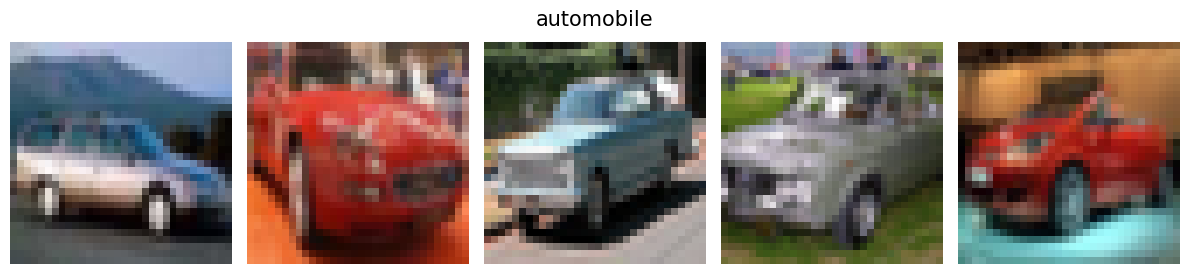

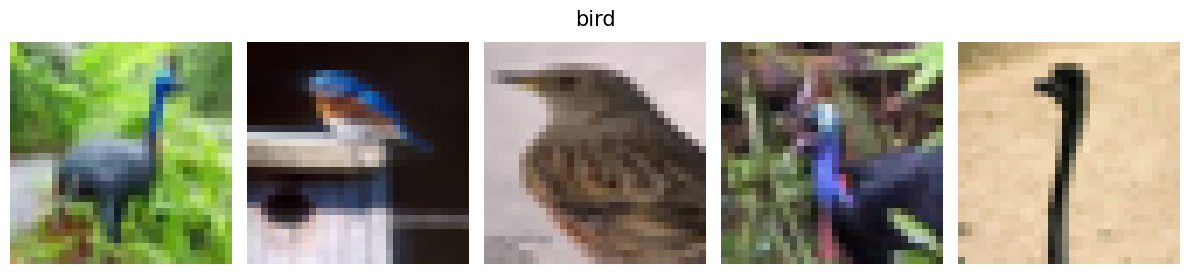

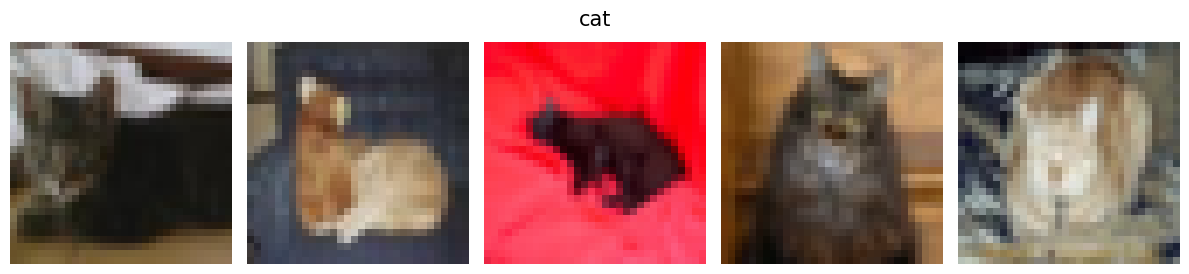

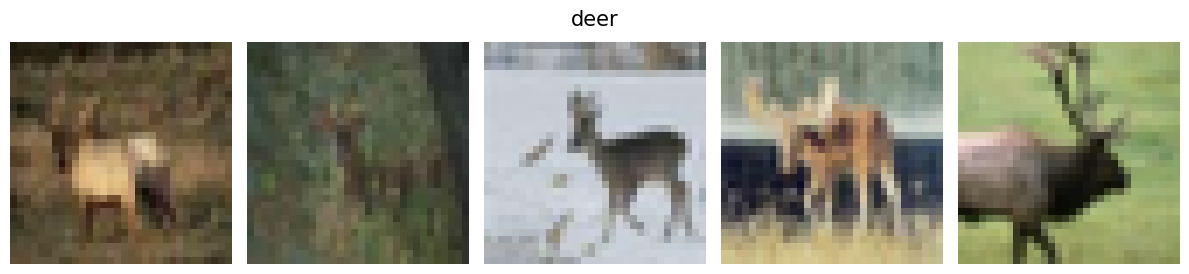

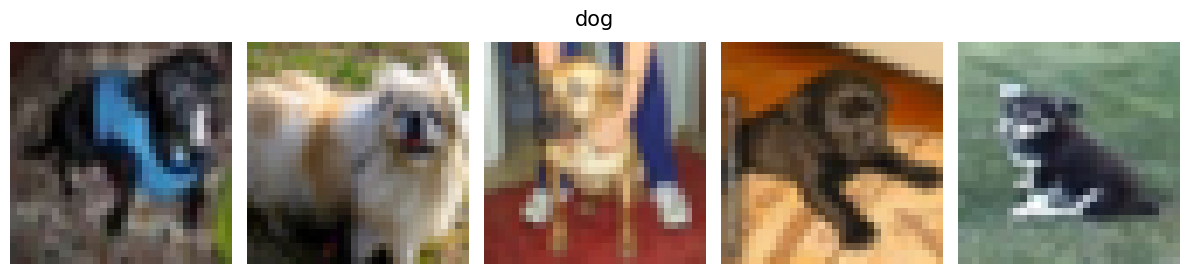

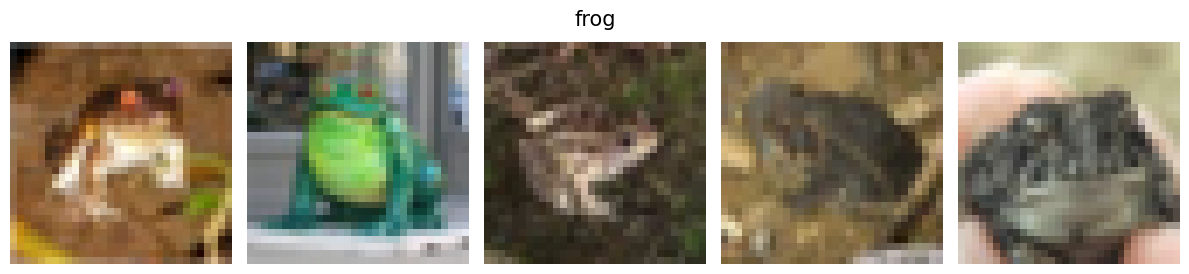

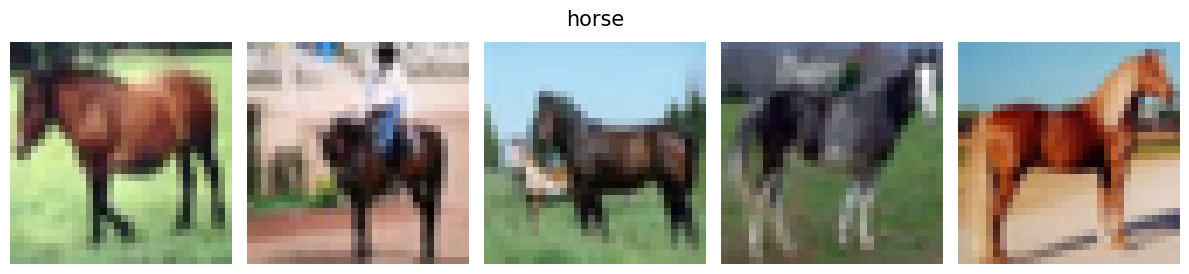

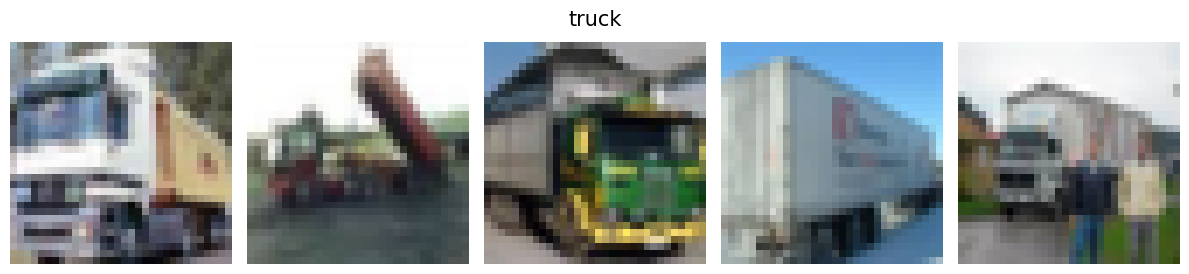

In [ ]:
for label in int_to_labels.keys():
  fig, axes = plt.subplots(1, 5, figsize = (12, 3))
  data = X_trainval[y_trainval == label][:5]
  axes[0].imshow(data[0])
  axes[0].axis('off')
  axes[1].imshow(data[1])
  axes[1].axis('off')
  axes[2].imshow(data[2])
  axes[2].axis('off')
  axes[3].imshow(data[3])
  axes[3].axis('off')
  axes[4].imshow(data[4])
  axes[4].axis('off')
  plt.tight_layout()
  plt.suptitle(f"{int_to_labels[label]}", fontsize = 15)
  plt.show()

Ora che abbiamo i dati importanti e che siamo convinti di aver resettato correttamente gli indici, controlliamo il data balancing. Eseguendo la prossima cella, vediamo a colpo d'occhio che il dataset e' perfettamente bilanciato, con 5000 campioni per classe:

In [ ]:
np.unique(y_trainval, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

Possiamo ora passare alla definizione del training e validation sets, che serviranno successivamente per fare cross-validation:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2,
                                                  random_state = seed, stratify = y_trainval,
                                                  shuffle = True)

Quando si tratta di classificazione di immagini, il primissimo tentativo che si puo' fare e' usare il transfer learning. In particolare si possono seguire vari approcci, in ordine crescente di tempo di training (ossia di parametri allenabili):

- Transfer learning 'puro': modificare la testa di classificazione di un modello pre-trainato con tutti i pesi congelati, ottenendo in pratica una logistic regression alla fine di un feature extractor;

- Transfer learning 'puro' + testa di classificazione: modificare la testa di classificazione, personalizzandola ed aggiungendo layers. Ovviamente, questo aggiunge molti piu' parametri extra;

- Fine tuning di alcuni layers + regressione logistica;

- Fine tuning di alcuni layers + classification head personalizzata.

In tutti i casi, e' importante aggiungere data augmentation per prevenire l'overfitting che di sicuro si palesera' nella maggior parte dei casi. Infatti i modelli allenati su imagenet hanno milioni di parametri e sono potentissimi, al punto da adattarsi (troppo) velocemente al nuovo dataset. La data augmentation e' la strategia di ordine zero per prevenire questo problema.

Se nessuno di questi metodi funziona, si puo' anche utilizzare un'architettura custom, definendola da zero.

Quindi nelle prossime sezioni si tentera' dapprima un approccio transfer learning/fine-tuning e poi un'architettura custom.

**Osservazione**: ci si aspetta che i modelli transfer learning e fine-tuning performino peggio di uno custom in questo specifico caso, perche' i modelli allenati su imagenet sono 'abituati' a trovare le features in immagini ad alta risoluzione (es 224x224). Quindi probabilmente non saranno altrettanto bravi con le immagini molto sfocate di cifar, che sono 32x32.

## Transfer Learning/Fine-Tuning

Nella cella seguente e' presente una funzione che copre i casi spiegati qui sopra, definendo una architettura che si basa su un certo backbone:

In [ ]:
clear_session()

def create_transfer_model(base_model_class,
                          preprocessing_function,
                          augmentation = None,
                          fine_tuning = None,
                          head = False,
                          input_shape = (32, 32, 3), num_classes = 2):
  """
  base_model_class: a pretrained model class, without the classification head, from tensorflow.keras.applications.
  preprocessing_function: a function preprocess_input of the same model as base_model_class.
  augmentation: a data augmentation object from the class tensorflow.keras.Sequential.
  fine_tuning: how many layers should be fine-tuned.
  head: if True, a non-trivial classification head is added to the base_model.
  return: a logistic regression model on top of the instantiation of the base_model_class.
  """
  inputs = Input(shape = input_shape)
  x = augmentation(inputs) if augmentation else inputs
  x = preprocessing_function(x)

  base_model = base_model_class(weights = 'imagenet', include_top = False, input_tensor = x)
  if fine_tuning:
    for layer in base_model.layers[:-fine_tuning]:
      layer.trainable = False
  else:
    for layer in base_model.layers:
      layer.trainable = False
  output_feature_extr = base_model.output

  averaged = GlobalAveragePooling2D()(output_feature_extr)
  x = Flatten()(averaged)

  if head:
    x = BatchNormalization()(x)
    x = Dense(200, activation = "relu")(x)
    x = Dropout(rate = 0.5)(x)

    x = BatchNormalization()(x)
    x = Dense(100, activation = "relu")(x)
    x = Dropout(rate = 0.4)(x)

  outputs = Dense(num_classes, activation = "softmax")(x)

  baseline_model = Model(inputs = inputs, outputs = outputs)
  return baseline_model

data_augmentation = Sequential([
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
    ])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
EPOCHS = 50
BATCH_SIZE = 128

### DenseNet121

In [ ]:
clear_session()

baseline_densenet = create_transfer_model(DenseNet121,
                                          densenet.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = None,
                                          head = False,
                                          num_classes = len(int_to_labels))

baseline_densenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_densenet.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             epochs = EPOCHS,
                             batch_size = BATCH_SIZE,
                             verbose = 1,
                             callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3396 - loss: 2.0253 - val_accuracy: 0.5935 - val_loss: 1.1263
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5339 - loss: 1.2781 - val_accuracy: 0.6191 - val_loss: 1.0542
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5633 - loss: 1.1941 - val_accuracy: 0.6389 - val_loss: 1.0047
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5757 - loss: 1.1583 - val_accuracy: 0.6429 - val_loss: 0.9866
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5918 - loss: 1.1330 - val_accuracy: 0.6488 - val_loss: 0.9709
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5836 - loss: 1.1320 - val_accuracy: 0.6511 - val_loss: 0.9614
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5939 - loss: 1.1184 - val_accuracy: 0.6525 - val_loss: 0.9638
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5947 - loss: 1.1112 - val_acc

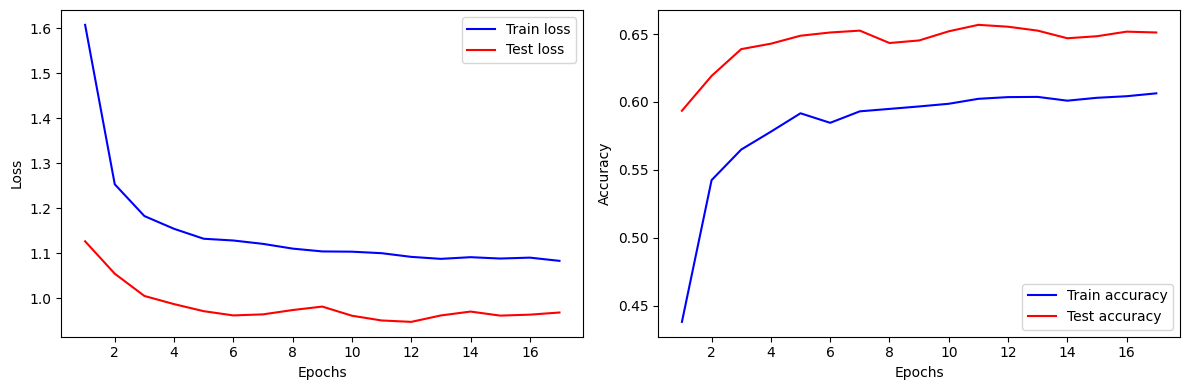

In [ ]:
plot_learning_curves(hist, size = (12, 4))

In [ ]:
clear_session()

baseline_densenet = create_transfer_model(DenseNet121,
                                          densenet.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = None,
                                          head = True,
                                          num_classes = len(int_to_labels))

baseline_densenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_densenet.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             epochs = EPOCHS,
                             batch_size = BATCH_SIZE,
                             verbose = 1,
                             callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.3488 - loss: 1.8315 - val_accuracy: 0.6140 - val_loss: 1.1213
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4987 - loss: 1.3512 - val_accuracy: 0.6447 - val_loss: 1.0302
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5376 - loss: 1.2592 - val_accuracy: 0.6569 - val_loss: 0.9520
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5544 - loss: 1.2098 - val_accuracy: 0.6666 - val_loss: 0.9222
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5705 - loss: 1.1765 - val_accuracy: 0.6724 - val_loss: 0.9083
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5776 - loss: 1.1642 - val_accuracy: 0.6761 - val_loss: 0.8952
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5840 - loss: 1.1490 - val_accuracy: 0.6808 - val_loss: 0.8783
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5960 - loss: 1.1266 - val_acc

In [ ]:
clear_session()

baseline_densenet = create_transfer_model(DenseNet121,
                                          densenet.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = 500,
                                          head = False,
                                          num_classes = len(int_to_labels))

baseline_densenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_densenet.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             epochs = EPOCHS,
                             batch_size = BATCH_SIZE,
                             verbose = 1,
                             callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 150ms/step - accuracy: 0.4776 - loss: 1.4812 - val_accuracy: 0.5347 - val_loss: 4.0415
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.7082 - loss: 0.8315 - val_accuracy: 0.6891 - val_loss: 0.9685
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - accuracy: 0.7503 - loss: 0.7187 - val_accuracy: 0.7266 - val_loss: 0.8250
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7648 - loss: 0.6655 - val_accuracy: 0.1511 - val_loss: 485.5739
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - accuracy: 0.7238 - loss: 0.7959 - val_accuracy: 0.7710 - val_loss: 0.6735
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - accuracy: 0.7700 - loss: 0.6456 - val_accuracy: 0.7550 - val_loss: 0.7493
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.7838 - loss: 0.6098 - val_accuracy: 0.7871 - val_loss: 0.6465
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.8010 - loss

In [ ]:
clear_session()

baseline_densenet = create_transfer_model(DenseNet121,
                                          densenet.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = 500,
                                          head = True,
                                          num_classes = len(int_to_labels))

baseline_densenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_densenet.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             epochs = EPOCHS,
                             batch_size = BATCH_SIZE,
                             verbose = 1,
                             callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 160ms/step - accuracy: 0.3285 - loss: 1.9151 - val_accuracy: 0.5443 - val_loss: 1.2427
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.6313 - loss: 1.0745 - val_accuracy: 0.6546 - val_loss: 1.0111
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.6855 - loss: 0.9392 - val_accuracy: 0.6626 - val_loss: 1.0046
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.7006 - loss: 0.8729 - val_accuracy: 0.6660 - val_loss: 1.0887
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.7279 - loss: 0.8138 - val_accuracy: 0.7255 - val_loss: 0.8028
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.7296 - loss: 0.7964 - val_accuracy: 0.5560 - val_loss: 1.4011
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7212 - loss: 0.8198 - val_accuracy: 0.7520 - val_loss: 0.6960
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.7594 - loss: 

### MobileNetV2

In [ ]:
clear_session()

baseline_mobilenet = create_transfer_model(MobileNetV2,
                                          mobilenet_v2.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = None,
                                          head = False,
                                          num_classes = len(int_to_labels))

baseline_mobilenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_mobilenet.fit(X_train, y_train,
                              validation_data = (X_val, y_val),
                              epochs = EPOCHS,
                              batch_size = BATCH_SIZE,
                              verbose = 1,
                              callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1866 - loss: 2.0320 - val_accuracy: 0.2544 - val_loss: 1.9557
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2665 - loss: 1.9184 - val_accuracy: 0.2715 - val_loss: 1.9135
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2814 - loss: 1.8800 - val_accuracy: 0.2780 - val_loss: 1.8911
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2872 - loss: 1.8556 - val_accuracy: 0.2774 - val_loss: 1.8791
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2859 - loss: 1.8454 - val_accuracy: 0.2788 - val_loss: 1.8696
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2874 - loss: 1.8394 - val_accuracy: 0.2789 - val_loss: 1.8639
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2911 - loss: 1.8280 - val_accuracy: 0.2803 - val_loss: 1.8605
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2872 - loss: 1.8273 - val_accu

In [ ]:
clear_session()

baseline_mobilenet = create_transfer_model(MobileNetV2,
                                          mobilenet_v2.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = None,
                                          head = True,
                                          num_classes = len(int_to_labels))

baseline_mobilenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_mobilenet.fit(X_train, y_train,
                              validation_data = (X_val, y_val),
                              epochs = EPOCHS,
                              batch_size = BATCH_SIZE,
                              verbose = 1,
                              callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1745 - loss: 2.3071 - val_accuracy: 0.2611 - val_loss: 1.9188
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2353 - loss: 1.9419 - val_accuracy: 0.2604 - val_loss: 1.8738
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2616 - loss: 1.8739 - val_accuracy: 0.2600 - val_loss: 1.8618
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2624 - loss: 1.8616 - val_accuracy: 0.2679 - val_loss: 1.8528
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2742 - loss: 1.8479 - val_accuracy: 0.2784 - val_loss: 1.8441
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2787 - loss: 1.8422 - val_accuracy: 0.2770 - val_loss: 1.8416
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2805 - loss: 1.8358 - val_accuracy: 0.2839 - val_loss: 1.8406
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2839 - loss: 1.8270 - val_acc

In [ ]:
clear_session()

baseline_mobilenet = create_transfer_model(MobileNetV2,
                                          mobilenet_v2.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = 1000,
                                          head = False,
                                          num_classes = len(int_to_labels))

baseline_mobilenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_mobilenet.fit(X_train, y_train,
                              validation_data = (X_val, y_val),
                              epochs = EPOCHS,
                              batch_size = BATCH_SIZE,
                              verbose = 1,
                              callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.3618 - loss: 1.8283 - val_accuracy: 0.2564 - val_loss: 9.9397
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.5612 - loss: 1.2274 - val_accuracy: 0.3129 - val_loss: 8.1047
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6155 - loss: 1.0889 - val_accuracy: 0.4157 - val_loss: 3.5781
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6418 - loss: 1.0045 - val_accuracy: 0.5630 - val_loss: 2.4775
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6457 - loss: 1.0058 - val_accuracy: 0.3344 - val_loss: 4.1515
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6402 - loss: 1.0257 - val_accuracy: 0.2128 - val_loss: 7.6087
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6496 - loss: 0.9757 - val_accuracy: 0.5825 - val_loss: 2.1383
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6579 - loss: 0.9651 - 

In [ ]:
clear_session()

baseline_mobilenet = create_transfer_model(MobileNetV2,
                                          mobilenet_v2.preprocess_input,
                                          data_augmentation,
                                          fine_tuning = 1000,
                                          head = True,
                                          num_classes = len(int_to_labels))

baseline_mobilenet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_mobilenet.fit(X_train, y_train,
                              validation_data = (X_val, y_val),
                              epochs = EPOCHS,
                              batch_size = BATCH_SIZE,
                              verbose = 1,
                              callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.2537 - loss: 2.0993 - val_accuracy: 0.4111 - val_loss: 1.8198
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.5232 - loss: 1.3171 - val_accuracy: 0.2916 - val_loss: 2.0412
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6183 - loss: 1.0959 - val_accuracy: 0.4341 - val_loss: 1.7137
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6586 - loss: 0.9883 - val_accuracy: 0.5695 - val_loss: 1.2792
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6831 - loss: 0.9169 - val_accuracy: 0.6269 - val_loss: 1.1547
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6989 - loss: 0.8695 - val_accuracy: 0.6439 - val_loss: 1.0933
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7161 - loss: 0.8315 - val_accuracy: 0.7053 - val_loss: 0.8888
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7250 - loss: 0.8037 - 

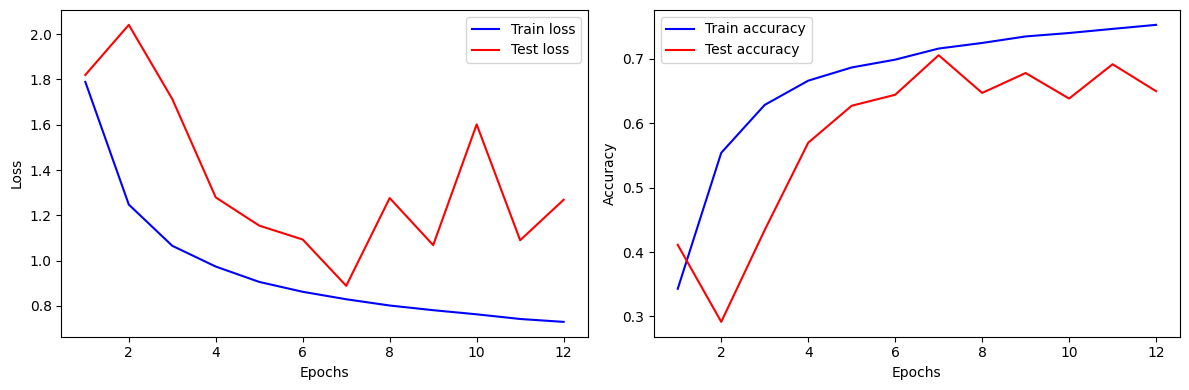

In [ ]:
plot_learning_curves(hist, size = (12, 4))

### EfficientNet

In [ ]:
clear_session()

baseline_efficientnet = create_transfer_model(EfficientNetB0,
                                              efficientnet.preprocess_input,
                                              data_augmentation,
                                              fine_tuning = None,
                                              head = False,
                                              num_classes = len(int_to_labels))

baseline_efficientnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_efficientnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.2913 - loss: 1.8518 - val_accuracy: 0.4874 - val_loss: 1.4663
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4264 - loss: 1.5635 - val_accuracy: 0.5096 - val_loss: 1.3795
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4499 - loss: 1.4903 - val_accuracy: 0.5194 - val_loss: 1.3472
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4531 - loss: 1.4684 - val_accuracy: 0.5275 - val_loss: 1.3190
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4718 - loss: 1.4354 - val_accuracy: 0.5375 - val_loss: 1.2923
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4753 - loss: 1.4273 - val_accuracy: 0.5362 - val_loss: 1.2833
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4742 - loss: 1.4190 - val_accuracy: 0.5386 - val_loss: 1.2686
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14

In [ ]:
clear_session()

baseline_efficientnet = create_transfer_model(EfficientNetB0,
                                              efficientnet.preprocess_input,
                                              data_augmentation,
                                              fine_tuning = None,
                                              head = True,
                                              num_classes = len(int_to_labels))

baseline_efficientnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_efficientnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.2858 - loss: 2.0047 - val_accuracy: 0.4939 - val_loss: 1.5785
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3987 - loss: 1.5842 - val_accuracy: 0.5411 - val_loss: 1.3226
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4335 - loss: 1.5050 - val_accuracy: 0.5524 - val_loss: 1.2274
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4477 - loss: 1.4709 - val_accuracy: 0.5558 - val_loss: 1.2063
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4610 - loss: 1.4393 - val_accuracy: 0.5656 - val_loss: 1.1869
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4686 - loss: 1.4198 - val_accuracy: 0.5651 - val_loss: 1.1768
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4711 - loss: 1.4258 - val_accuracy: 0.5701 - val_loss: 1.1669
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4859 - loss: 1.3986 - val_acc

In [ ]:
clear_session()

baseline_efficientnet = create_transfer_model(EfficientNetB0,
                                              efficientnet.preprocess_input,
                                              data_augmentation,
                                              fine_tuning = 1000,
                                              head = False,
                                              num_classes = len(int_to_labels))

baseline_efficientnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_efficientnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.4383 - loss: 1.5799 - val_accuracy: 0.6601 - val_loss: 1.0871
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.6663 - loss: 0.9359 - val_accuracy: 0.7300 - val_loss: 0.8231
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7160 - loss: 0.8022 - val_accuracy: 0.7337 - val_loss: 0.7788
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.7440 - loss: 0.7283 - val_accuracy: 0.7695 - val_loss: 0.6749
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7607 - loss: 0.6766 - val_accuracy: 0.7358 - val_loss: 0.8097
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.7724 - loss: 0.6414 - val_accuracy: 0.7321 - val_loss: 0.8328
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7886 - loss: 0.5989 - val_accuracy: 0.7726 - val_loss: 0.7246
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7905 - loss: 0.5859 - 

In [ ]:
clear_session()

baseline_efficientnet = create_transfer_model(EfficientNetB0,
                                              efficientnet.preprocess_input,
                                              data_augmentation,
                                              fine_tuning = 1000,
                                              head = True,
                                              num_classes = len(int_to_labels))

baseline_efficientnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_efficientnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 77ms/step - accuracy: 0.2827 - loss: 2.0673 - val_accuracy: 0.5990 - val_loss: 1.2640
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.5995 - loss: 1.1585 - val_accuracy: 0.6600 - val_loss: 1.1139
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.6733 - loss: 0.9498 - val_accuracy: 0.7193 - val_loss: 0.8202
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.7025 - loss: 0.8648 - val_accuracy: 0.7182 - val_loss: 0.8211
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.7290 - loss: 0.7946 - val_accuracy: 0.7470 - val_loss: 0.7218
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.7456 - loss: 0.7517 - val_accuracy: 0.7372 - val_loss: 0.7661
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.7565 - loss: 0.7211 - val_accuracy: 0.7734 - val_loss: 0.6582
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.7670 - loss: 0.6828 - 

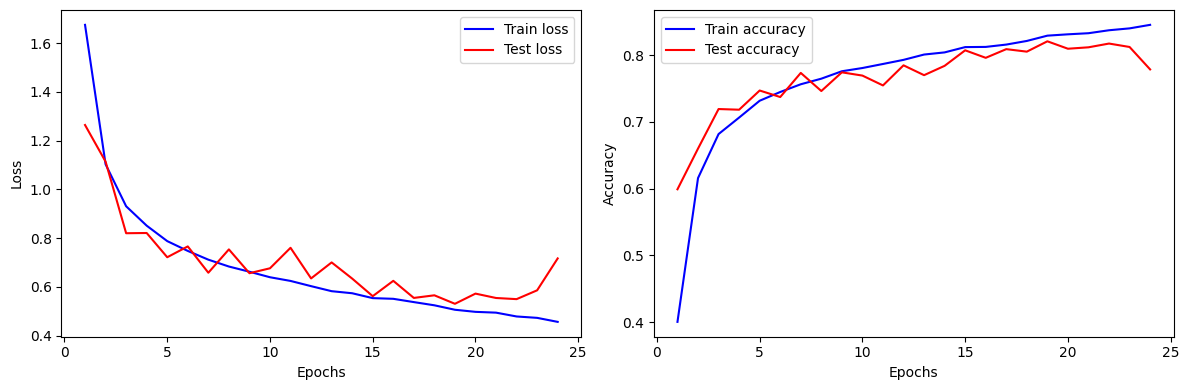

In [ ]:
plot_learning_curves(hist, size = (12, 4))

### ResNet50

In [ ]:
clear_session()

baseline_resnet = create_transfer_model(ResNet50,
                                        resnet50.preprocess_input,
                                        data_augmentation,
                                        fine_tuning = None,
                                        head = False,
                                        num_classes = len(int_to_labels))

baseline_resnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_resnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.3919 - loss: 2.3656 - val_accuracy: 0.5723 - val_loss: 1.3461
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5204 - loss: 1.4500 - val_accuracy: 0.6071 - val_loss: 1.1911
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5504 - loss: 1.3419 - val_accuracy: 0.6177 - val_loss: 1.1643
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5579 - loss: 1.2845 - val_accuracy: 0.6206 - val_loss: 1.1502
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5688 - loss: 1.2523 - val_accuracy: 0.6269 - val_loss: 1.1245
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5635 - loss: 1.2609 - val_accuracy: 0.6280 - val_loss: 1.1280
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5792 - loss: 1.2147 - val_accuracy: 0.6170 - val_loss: 1.1394
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14

In [ ]:
clear_session()

baseline_resnet = create_transfer_model(ResNet50,
                                        resnet50.preprocess_input,
                                        data_augmentation,
                                        fine_tuning = None,
                                        head = True,
                                        num_classes = len(int_to_labels))

baseline_resnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_resnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.3351 - loss: 1.8830 - val_accuracy: 0.5956 - val_loss: 1.1196
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4864 - loss: 1.4069 - val_accuracy: 0.6246 - val_loss: 1.0540
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5157 - loss: 1.3203 - val_accuracy: 0.6361 - val_loss: 1.0296
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5345 - loss: 1.2733 - val_accuracy: 0.6432 - val_loss: 1.0085
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5388 - loss: 1.2539 - val_accuracy: 0.6413 - val_loss: 1.0007
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5534 - loss: 1.2188 - val_accuracy: 0.6455 - val_loss: 0.9831
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5591 - loss: 1.2052 - val_accuracy: 0.6450 - val_loss: 0.9884
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5612 - loss: 1.2015 - val_acc

In [ ]:
clear_session()

baseline_resnet = create_transfer_model(ResNet50,
                                        resnet50.preprocess_input,
                                        data_augmentation,
                                        fine_tuning = 1000,
                                        head = False,
                                        num_classes = len(int_to_labels))

baseline_resnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_resnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - accuracy: 0.3991 - loss: 1.9713 - val_accuracy: 0.6044 - val_loss: 2.6977
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.5918 - loss: 1.1647 - val_accuracy: 0.2150 - val_loss: 1720.8417
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.5195 - loss: 1.3909 - val_accuracy: 0.6241 - val_loss: 1.0877
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.6446 - loss: 1.0217 - val_accuracy: 0.1456 - val_loss: 1000.7699
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.5411 - loss: 1.3777 - val_accuracy: 0.5156 - val_loss: 1.8379
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.6210 - loss: 1.1015 - val_accuracy: 0.5561 - val_loss: 1.4116
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.6410 - loss: 1.0320 - val_accuracy: 0.6565 - val_loss: 0.9588
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.6236 - loss: 1.1

In [ ]:
clear_session()

baseline_resnet = create_transfer_model(ResNet50,
                                        resnet50.preprocess_input,
                                        data_augmentation,
                                        fine_tuning = 1000,
                                        head = True,
                                        num_classes = len(int_to_labels))

baseline_resnet.compile(optimizer = Adam(learning_rate = 0.001),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_resnet.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                verbose = 1,
                                callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2909 - loss: 1.9944 - val_accuracy: 0.5798 - val_loss: 1.3573
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.5775 - loss: 1.2111 - val_accuracy: 0.6685 - val_loss: 0.9438
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.6475 - loss: 1.0359 - val_accuracy: 0.6611 - val_loss: 1.1717
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.6629 - loss: 0.9691 - val_accuracy: 0.6359 - val_loss: 1.1563
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.6903 - loss: 0.9170 - val_accuracy: 0.7110 - val_loss: 0.8431
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.7092 - loss: 0.8747 - val_accuracy: 0.7246 - val_loss: 0.7783
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7127 - loss: 0.8571 - val_accuracy: 0.6579 - val_loss: 1.1355
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7269 - loss: 0.8126 - 

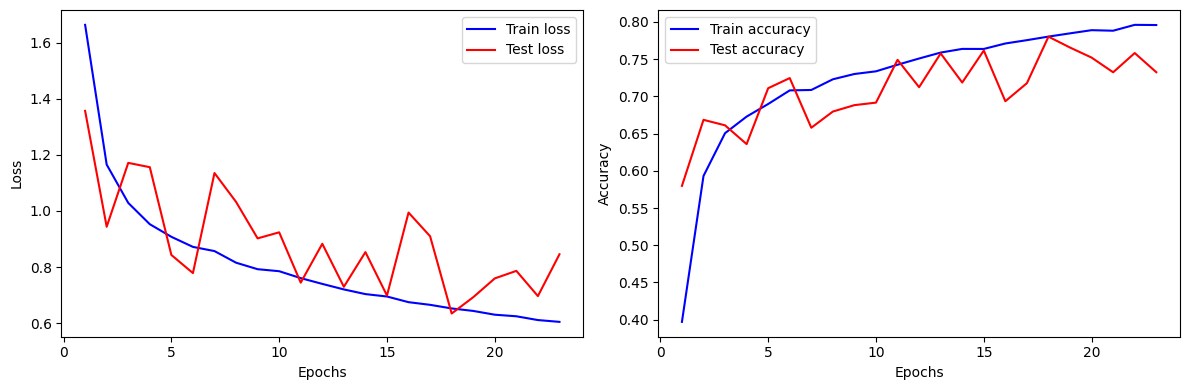

In [ ]:
plot_learning_curves(hist, size = (12, 4))

### VGG16

In [ ]:
clear_session()

baseline_vgg16 = create_transfer_model(VGG16,
                                       vgg16.preprocess_input,
                                       data_augmentation,
                                       fine_tuning = None,
                                       head = False,
                                       num_classes = len(int_to_labels))

baseline_vgg16.compile(optimizer = Adam(learning_rate = 0.0005),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_vgg16.fit(X_train, y_train,
                          validation_data = (X_val, y_val),
                          epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          verbose = 1,
                          callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2080 - loss: 14.1281 - val_accuracy: 0.4283 - val_loss: 5.8567
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4163 - loss: 5.0241 - val_accuracy: 0.4916 - val_loss: 3.7894
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4559 - loss: 3.4438 - val_accuracy: 0.5109 - val_loss: 2.7490
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4840 - loss: 2.4814 - val_accuracy: 0.5375 - val_loss: 2.0131
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5028 - loss: 1.9404 - val_accuracy: 0.5696 - val_loss: 1.5936
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5249 - loss: 1.5898 - val_accuracy: 0.5995 - val_loss: 1.3282
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5452 - loss: 1.4106 - val_accuracy: 0.6152 - val_loss: 1.2111
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5450 - loss: 1.3263 - val_accuracy: 0

In [ ]:
clear_session()

baseline_vgg16 = create_transfer_model(VGG16,
                                       vgg16.preprocess_input,
                                       data_augmentation,
                                       fine_tuning = None,
                                       head = True,
                                       num_classes = len(int_to_labels))

baseline_vgg16.compile(optimizer = Adam(learning_rate = 0.0005),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_vgg16.fit(X_train, y_train,
                          validation_data = (X_val, y_val),
                          epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          verbose = 1,
                          callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2409 - loss: 2.1856 - val_accuracy: 0.5569 - val_loss: 1.2406
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4103 - loss: 1.5884 - val_accuracy: 0.5879 - val_loss: 1.1403
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4587 - loss: 1.4604 - val_accuracy: 0.6005 - val_loss: 1.0995
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4817 - loss: 1.3960 - val_accuracy: 0.6131 - val_loss: 1.0719
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4986 - loss: 1.3538 - val_accuracy: 0.6220 - val_loss: 1.0518
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5144 - loss: 1.3199 - val_accuracy: 0.6269 - val_loss: 1.0390
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5240 - loss: 1.3074 - val_accuracy: 0.6320 - val_loss: 1.0235
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5319 - loss: 1.2799 - val_accuracy: 0

In [ ]:
clear_session()

baseline_vgg16 = create_transfer_model(VGG16,
                                       vgg16.preprocess_input,
                                       data_augmentation,
                                       fine_tuning = 1000,
                                       head = False,
                                       num_classes = len(int_to_labels))

baseline_vgg16.compile(optimizer = Adam(learning_rate = 0.0005),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_vgg16.fit(X_train, y_train,
                          validation_data = (X_val, y_val),
                          epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          verbose = 1,
                          callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1212 - loss: 2.9258 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1180 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1194 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1195 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1198 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1206 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1209 - loss: 2.0795 - val_accuracy: 0.1250 - val_loss: 2.0794
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1208 - loss: 2.0795 - val_accu

In [ ]:
clear_session()

baseline_vgg16 = create_transfer_model(VGG16,
                                       vgg16.preprocess_input,
                                       data_augmentation,
                                       fine_tuning = 1000,
                                       head = True,
                                       num_classes = len(int_to_labels))

baseline_vgg16.compile(optimizer = Adam(learning_rate = 0.0005),
                              loss = 'sparse_categorical_crossentropy',
                              metrics = ['accuracy'])

hist = baseline_vgg16.fit(X_train, y_train,
                          validation_data = (X_val, y_val),
                          epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          verbose = 1,
                          callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1869 - loss: 2.2678 - val_accuracy: 0.2459 - val_loss: 1.8007
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2767 - loss: 1.7866 - val_accuracy: 0.2861 - val_loss: 1.7505
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3449 - loss: 1.5915 - val_accuracy: 0.1250 - val_loss: 48.4921
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2853 - loss: 1.7594 - val_accuracy: 0.1664 - val_loss: 2.2575
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3804 - loss: 1.5203 - val_accuracy: 0.3244 - val_loss: 11.0056
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4348 - loss: 1.4145 - val_accuracy: 0.4044 - val_loss: 1.4798
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4938 - loss: 1.3085 - val_accuracy: 0.2777 - val_loss: 4.4448
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5264 - loss: 1.2306 - val_a

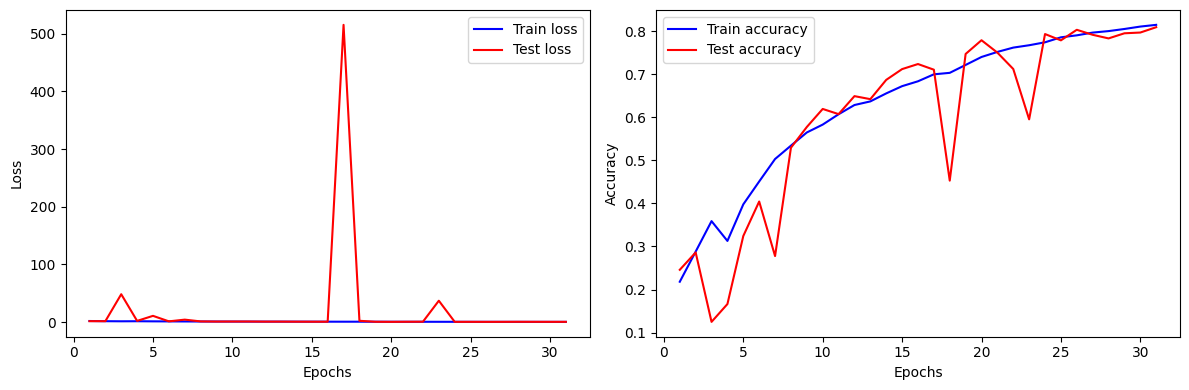

In [ ]:
plot_learning_curves(hist, size = (12, 4))

## Custom Architectures

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128

### Type 1

Avendo capito che il problema e' troppo 'semplice' per le architettura utilizzate sopra, definiamo una architettura custom. Prendiamo ispirazione dall'architettura di VGG ed usiamo tre blocchi conv-conv-pool (così da avere una profondita' minore di VGG, che ha 5 blocchi di questo tipo, ma comunque una simile capacita' di comprendere le features). Sfruttiamo anche similmente l'idea di utilizzare solo filtri di dimensione 3 con strides di dimensione 1:

In [ ]:
clear_session()

inputs = Input(shape = (32, 32, 3))

data_augmentation = Sequential([
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.Rescaling(1/np.max(X_train))], name = 'Data_preprocessing')

block_1 = Sequential([ # for simple features
    # input shape: (32, 32, 3)
    Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'), # shape: (32, 32, 32)
    Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'), # shape: (32, 32, 32)
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(rate = 0.1)], name = 'Block_1') # output shape: (16, 16, 32)

block_2 = Sequential([ # for medium features
    # input shape: (16, 16, 32)
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'), # shape: (16, 16, 64)
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'), # shape: (16, 16, 64)
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(rate = 0.1)], name = 'Block_2')# output shape: (8, 8, 64)

block_3 = Sequential([ # for complicated features
    # input shape: (8, 8, 64)
    Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'), # shape: (8, 8, 128)
    Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    BatchNormalization(),
    Activation('relu'), # shape: (8, 8, 128)
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)), # shape: (4, 4, 128)
    Dropout(rate = 0.1)], name = 'Block_3') # output shape: (4, 4, 128)

classification_head = Sequential([
    # input shape: (4, 4, 128)
    GlobalAveragePooling2D(), # shape: (128, )
    Dense(200, activation = None),
    BatchNormalization(),
    Activation('relu'),
    # Dropout(rate = 0.1),
    Dense(100, activation = None),
    BatchNormalization(),
    Activation('relu'),
    # Dropout(rate = 0.1),
    Dense(len(int_to_labels), activation = 'softmax')], name = 'Classification_Head')

outputs = classification_head(block_3(block_2(block_1(data_augmentation(inputs)))))

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

my_model = Model(inputs = inputs, outputs = outputs)

my_model.compile(optimizer = Adam(learning_rate = 0.01),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

hist = my_model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    callbacks = [early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.2730 - loss: 1.8355 - val_accuracy: 0.2419 - val_loss: 2.7438
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.4373 - loss: 1.4700 - val_accuracy: 0.3634 - val_loss: 2.1908
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5055 - loss: 1.3173 - val_accuracy: 0.5225 - val_loss: 1.3574
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5513 - loss: 1.2041 - val_accuracy: 0.4991 - val_loss: 1.6367
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5941 - loss: 1.1092 - val_accuracy: 0.5102 - val_loss: 1.3280
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.6244 - loss: 1.0360 - val_accuracy: 0.6489 - val_loss: 0.9965
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.6448 - loss: 0.9748 - val_accuracy: 0.5142 - val_loss: 1.5680
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.6697 - loss: 0.9135 - val_acc

### Type 2

I risultati non sono ancora soddisfacenti, proviamo un'architettura un pochino piu' complessa:

In [ ]:
clear_session()

inputs = Input(shape = (32, 32, 3))

data_augmentation = Sequential([
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.Rescaling(1/np.max(X_train))], name = 'Data_preprocessing')

block_1 = Sequential([ # for simple features
    # input shape: (32, 32, 3)
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (32, 32, 64)
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (32, 32, 128)
    Activation('relu'),
    Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (32, 32, 128)
    Activation('relu'),
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)), # shape: (16, 16, 128)
    Dropout(rate = 0.2)], name = 'CNN_1') # output shape: (16, 16, 128)

block_2 = Sequential([ # for medium features
    # input shape: (16, 16, 128)
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (16, 16, 256)
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (16, 16, 256)
    Activation('relu'),
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    Activation('relu'),
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)), # shape: (8, 8, 256)
    Dropout(rate = 0.2)], name = 'CNN_2')# output shape: (8, 8, 256)

block_3 = Sequential([ # for complicated features
    # input shape: (8, 8, 256)
    Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (8, 8, 512)
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (8, 8, 512)
    Activation('relu'),
    Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    Activation('relu'),
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)), # shape: (4, 4, 512)
    Dropout(rate = 0.2)], name = 'CNN_3') # output shape: (4, 4, 512)

classification_head = Sequential([
    # input shape: (4, 4, 512)
    GlobalAveragePooling2D(), # shape: (512, )
    Dense(512, activation = None),
    Activation('relu'),
    Dense(256, activation = None),
    Activation('relu'),
    Dropout(rate = 0.2),
    Dense(len(int_to_labels), activation = 'softmax')], name = 'Classification_Head')

outputs = classification_head(block_3(block_2(block_1(data_augmentation(inputs)))))

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss',
                                 factor = 0.1,
                                 patience = 10,
                                 min_lr = 1e-5)

my_model = Model(inputs = inputs, outputs = outputs)

my_model.compile(optimizer = AdamW(learning_rate = 0.001,
                                   weight_decay = 1e-6),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

hist = my_model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    callbacks = [early_stopping, lr_scheduler])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.2340 - loss: 1.9685 - val_accuracy: 0.1254 - val_loss: 2.9506 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - accuracy: 0.3601 - loss: 1.6315 - val_accuracy: 0.4051 - val_loss: 1.5610 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.4241 - loss: 1.5070 - val_accuracy: 0.4436 - val_loss: 1.4981 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.4734 - loss: 1.3775 - val_accuracy: 0.4425 - val_loss: 1.4996 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.5165 - loss: 1.2872 - val_accuracy: 0.4949 - val_loss: 1.3739 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.5464 - loss: 1.2145 - val_accuracy: 0.5326 - val_loss: 1.2606 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accura

In [ ]:
file_path = 'custom_cnn_0.001.keras'
my_model.save(file_path)

from google.colab import files
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

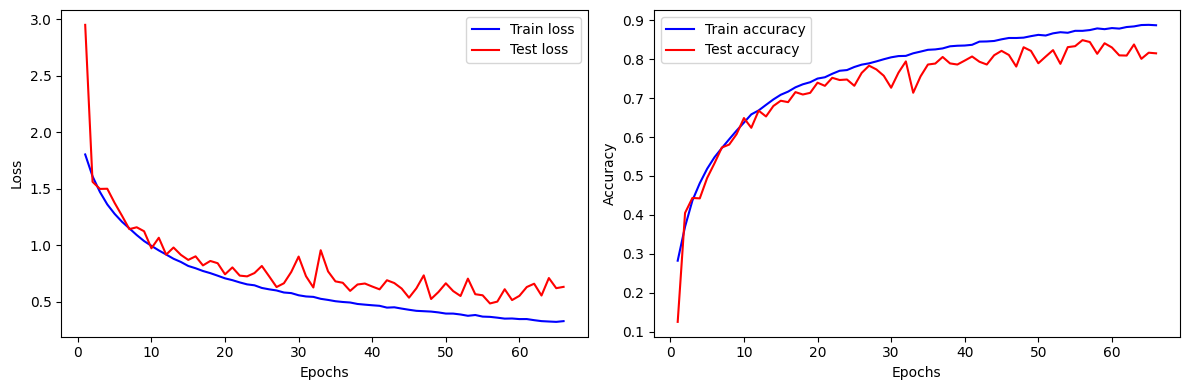

In [ ]:
plot_learning_curves(hist, size = (12, 4))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


,Accuracy,F1-score,Precision,Recall
Train,0.863156,0.857768,0.880101,0.863156


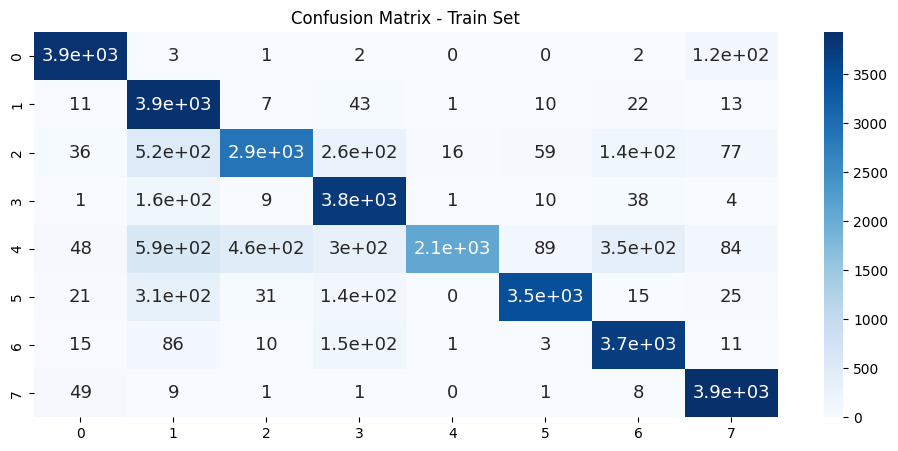

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


,Accuracy,F1-score,Precision,Recall
Validation,0.815,0.808386,0.84031,0.815


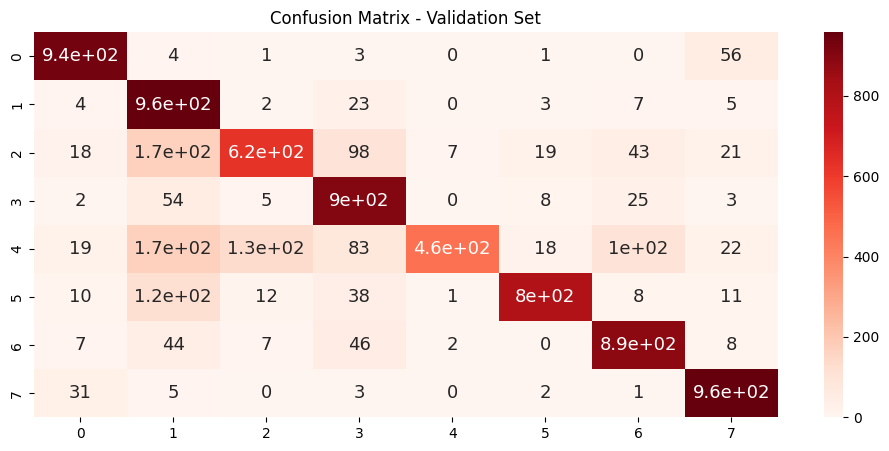

In [ ]:
_, _, _, = metrics_report(my_model, X_train, y_train, split = "Train", size = (12,5), verbose = True)
_, _, _, = metrics_report(my_model, X_val, y_val, split = "Validation", size = (12,5), verbose = True)

Questa architettura sembra buona (accuracy 86%-81%), proviamo anche un learning rate piu' basso (dopo aver ri-inizializzato i pesi nei layers):

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss',
                                 factor = 0.1,
                                 patience = 10,
                                 min_lr = 1e-5)

my_model = Model(inputs = inputs, outputs = outputs)

my_model.compile(optimizer = AdamW(learning_rate = 0.0005,
                                   weight_decay = 1e-6),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

hist = my_model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    callbacks = [early_stopping, lr_scheduler])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.2529 - loss: 1.8495 - val_accuracy: 0.1251 - val_loss: 3.4669 - learning_rate: 5.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.4344 - loss: 1.4720 - val_accuracy: 0.4971 - val_loss: 1.3461 - learning_rate: 5.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.5104 - loss: 1.2999 - val_accuracy: 0.5315 - val_loss: 1.2552 - learning_rate: 5.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.5592 - loss: 1.1819 - val_accuracy: 0.5494 - val_loss: 1.2402 - learning_rate: 5.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.5969 - loss: 1.0893 - val_accuracy: 0.5619 - val_loss: 1.2264 - learning_rate: 5.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.6332 - loss: 1.0020 - val_accuracy: 0.5485 - val_loss: 1.2792 - learning_rate: 5.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
file_path = 'custom_cnn_0.0005.keras'
my_model.save(file_path)

from google.colab import files
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

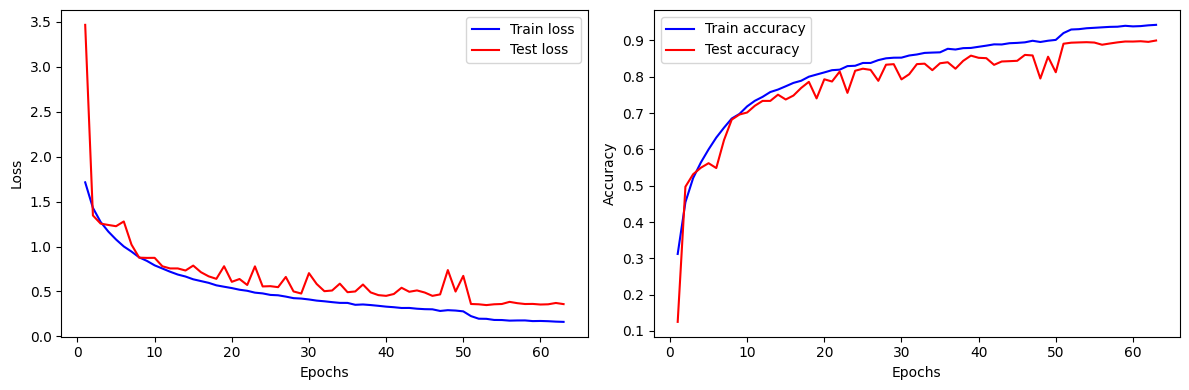

In [ ]:
plot_learning_curves(hist, size = (12, 4))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


,Accuracy,F1-score,Precision,Recall
Train,0.954875,0.954706,0.955084,0.954875


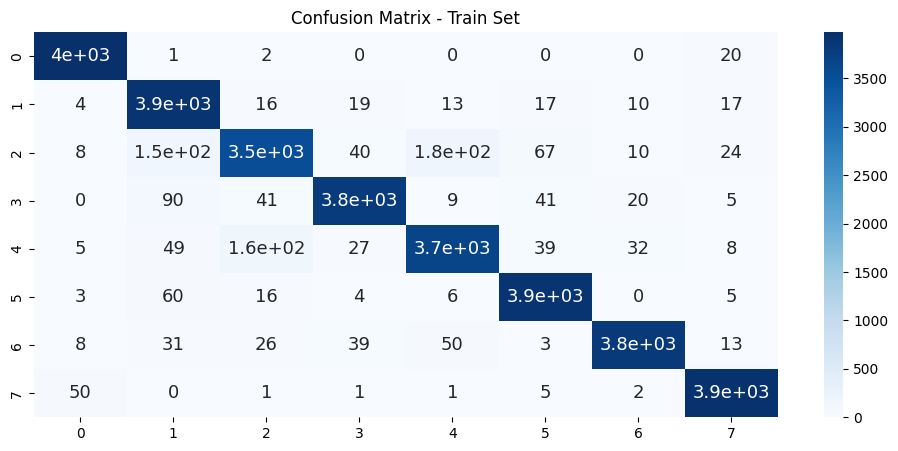

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,Accuracy,F1-score,Precision,Recall
Validation,0.899625,0.899445,0.900146,0.899625


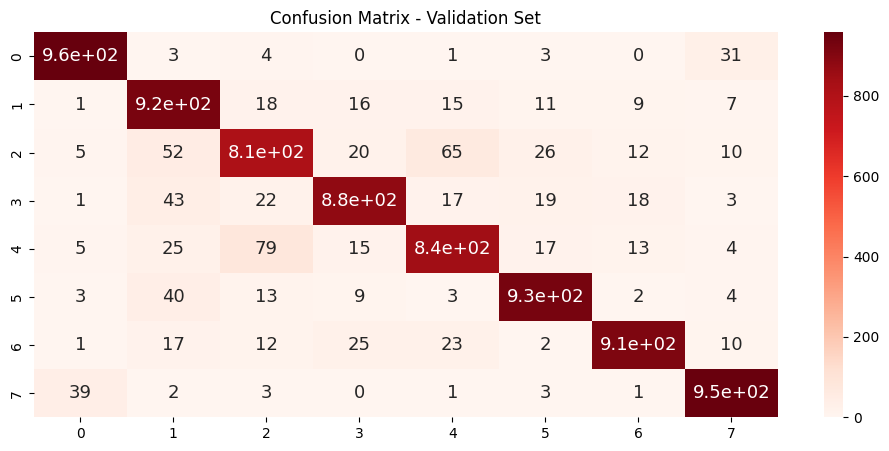

In [ ]:
_, _, _, = metrics_report(my_model, X_train, y_train, split = "Train", size = (12,5), verbose = True)
_, _, _, = metrics_report(my_model, X_val, y_val, split = "Validation", size = (12,5), verbose = True)

## Test and Discussion

Possiamo passare alle metriche di test usando finalmente il test set:

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


,Accuracy,F1-score,Precision,Recall
Test,0.814375,0.807318,0.836679,0.814375


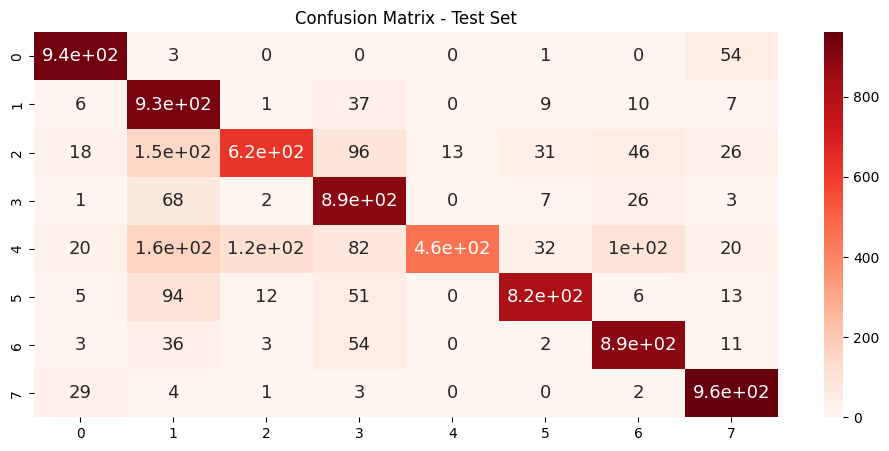

In [ ]:
file_path = 'custom_cnn_0.001.keras'
loaded_model_001 = load_model(file_path)
_, _, _, = metrics_report(loaded_model_001, X_test, y_test, split = "Test", size = (12,5), verbose = True)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


,Accuracy,F1-score,Precision,Recall
Test,0.890625,0.890218,0.890749,0.890625


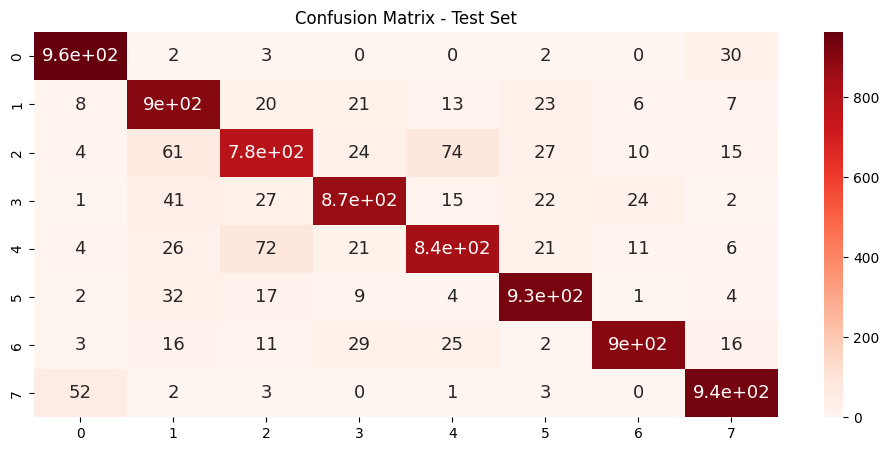

In [ ]:
file_path = 'custom_cnn_0.0005.keras'
loaded_model_01 = load_model(file_path)
_, _, _, = metrics_report(loaded_model_01, X_test, y_test, split = "Test", size = (12,5), verbose = True)

Con non poca fatica, abbiamo sviluppato un modello che e' in grado di distinguere animali e veicoli utilizzando una nostra versione di cifar10, che potremo chiamare 'cifar8'. Con piu' tempo e risorse a disposizione, sarebbe utile cercare di migliorare l'overfitting modificando la regolarizzazione `weight_decay` ed i vari dropout/batch normalization. Per gli scopi di questo progetto, ci riteniamo soddisfatti dei seguenti risultati. Le metriche migliori sono quelle ottenute con un learning rate iniziale $\eta_0 = 0.0005$. Tenendo in considerazione come metriche principali accuracy e precision (come da specifiche del progetto), siamo arrivati a valori soddisfacenti pari a:

- Accuracy: 89%;

- Precision: 89%.

Come ulteriore osservazione, notiamo che le classi su cui il modello e' piu' confuso sono 2 e 4, cioe' 'cat' e 'dog'. Essendo le immagini a bassa risoluzione, e' un errore accettabile. Da notare che i valori sul test set sono sovrapponibili a quelli sul validation set, indicativo del fatto che il modello generalizza molto bene!

## Two-classes Classification

Visto che lo scopo e' distinguere animali da veicoli per avvisare gli autisti della presenza di animali, potremmo anche affrontare il problema come classificazione a due classi: veicoli versus animali. Il costo, ovviamente, e' ottenere classi sbilanciate.

In [ ]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape # np array with shape (50000, 32, 32, 3)
y_train.shape # np array with shape (50000, 1)
X_test.shape # np array with shape (10000, 32, 32, 3)
y_test.shape # np array with shape (10000, 1)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
int_to_labels = {i:label for i,label in enumerate(labels)}
labels_to_int = {label:i for i,label in enumerate(labels)}  # {'airplane': 0,
                                                            # 'automobile': 1,
                                                            # 'bird': 2,
                                                            # 'cat': 3,
                                                            # 'deer': 4,
                                                            # 'dog': 5,
                                                            # 'frog': 6,
                                                            # 'horse': 7,
                                                            # 'ship': 8,
                                                            # 'truck': 9}
not_interesting_labels = [0, 8]
def filter_data(X, y, not_interesting_labels):
    mask = ~np.isin(y, not_interesting_labels).squeeze()
    return X[mask], y[mask]

X_trainval, y_trainval = filter_data(X_train, y_train, not_interesting_labels)
X_test, y_test = filter_data(X_test, y_test, not_interesting_labels)

le = LabelEncoder()
y_trainval = le.fit_transform(y_trainval)
y_test = le.transform(y_test)

int_to_labels =  {0: 'automobile',
                  1: 'bird',
                  2: 'cat',
                  3: 'deer',
                  4: 'dog',
                  5: 'frog',
                  6: 'horse',
                  7: 'truck'}

In [ ]:
new_labels_map = {0:0, 7:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}
map_func = np.vectorize(new_labels_map.get)
y_trainval = map_func(y_trainval.ravel())
y_test = map_func(y_test.ravel())
int_to_labels = {0: 'vehicle', 1: 'animal'}

Testiamo l'unbalancing fra le classi:

In [ ]:
print(np.unique(y_trainval, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([0, 1]), array([10000, 30000]))
(array([0, 1]), array([2000, 6000]))


Diviamo i dataset come prima:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2,
                                                  random_state = seed, stratify = y_trainval,
                                                  shuffle = True)

Ricicliamo la parte di feature extraction ma diminuiamo la dimensione della testa di classificazione:

In [ ]:
clear_session()

inputs = Input(shape = (32, 32, 3))

data_augmentation = Sequential([
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.Rescaling(1/np.max(X_train))], name = 'Data_preprocessing')

block_1 = Sequential([ # for simple features
    # input shape: (32, 32, 3)
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (32, 32, 64)
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (32, 32, 128)
    Activation('relu'),
    Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (32, 32, 128)
    Activation('relu'),
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)), # shape: (16, 16, 128)
    Dropout(rate = 0.2)], name = 'CNN_1') # output shape: (16, 16, 128)

block_2 = Sequential([ # for medium features
    # input shape: (16, 16, 128)
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (16, 16, 256)
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (16, 16, 256)
    Activation('relu'),
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    Activation('relu'),
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)), # shape: (8, 8, 256)
    Dropout(rate = 0.2)], name = 'CNN_2')# output shape: (8, 8, 256)

block_3 = Sequential([ # for complicated features
    # input shape: (8, 8, 256)
    Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (8, 8, 512)
    BatchNormalization(),
    Activation('relu'),
    Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None), # shape: (8, 8, 512)
    Activation('relu'),
    Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = None),
    Activation('relu'),
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)), # shape: (4, 4, 512)
    Dropout(rate = 0.2)], name = 'CNN_3') # output shape: (4, 4, 512)

classification_head = Sequential([
    # input shape: (4, 4, 512)
    GlobalAveragePooling2D(), # shape: (512, )
    Dense(100, activation = None),
    Activation('relu'),
    Dense(50, activation = None),
    Activation('relu'),
    Dropout(rate = 0.2),
    Dense(len(int_to_labels), activation = 'softmax')], name = 'Classification_Head')

augmented = data_augmentation(inputs)
x = block_1(augmented)
x = block_2(x)
x = block_3(x)
outputs = classification_head(x)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

my_model = Model(inputs = inputs, outputs = outputs)

my_model.compile(optimizer = SGD(learning_rate = 0.0005),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

hist = my_model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 10,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    callbacks = [early_stopping])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.6910 - loss: 0.6103 - val_accuracy: 0.7500 - val_loss: 0.5623
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7493 - loss: 0.5255 - val_accuracy: 0.7500 - val_loss: 0.5472
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7853 - loss: 0.4531 - val_accuracy: 0.8140 - val_loss: 0.3871
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.8218 - loss: 0.3965 - val_accuracy: 0.8690 - val_loss: 0.3276
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.8352 - loss: 0.3675 - val_accuracy: 0.8789 - val_loss: 0.3063
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.8487 - loss: 0.3452 - val_accuracy: 0.8860 - val_loss: 0.2895
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.8582 - loss: 0.3291 - val_accuracy: 0.8992 - val_loss: 0.2626
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.8678 - loss: 0

In [ ]:
file_path = 'two_classes.keras'
my_model.save(file_path)

from google.colab import files
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

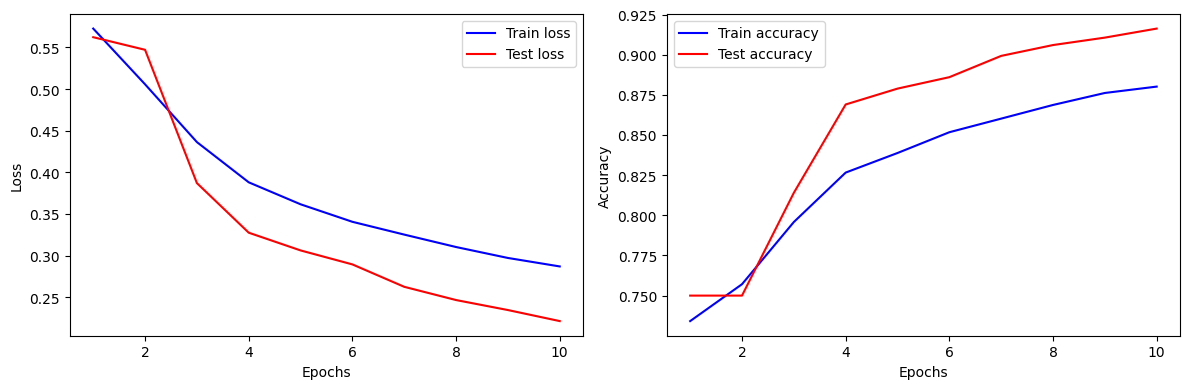

In [ ]:
plot_learning_curves(hist, size = (12, 4))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


,Accuracy,F1-score,Precision,Recall
Train,0.915312,0.884409,0.894259,0.875708


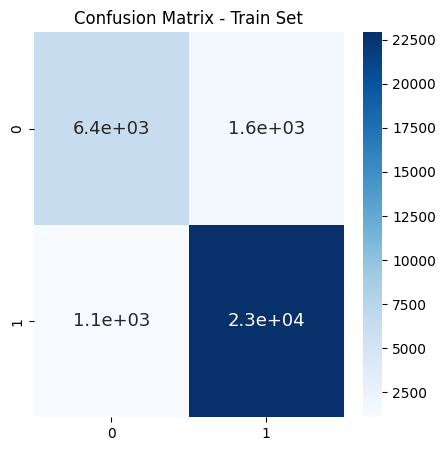

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


,Accuracy,F1-score,Precision,Recall
Validation,0.91625,0.886495,0.893218,0.880333


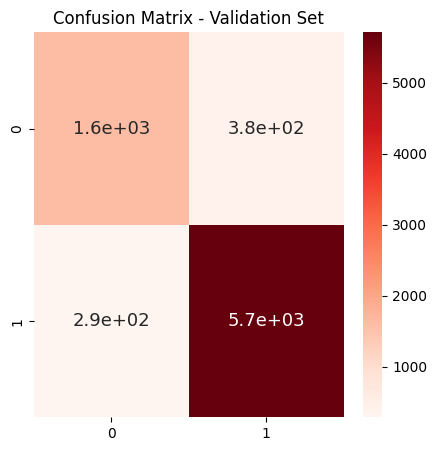

In [ ]:
_, _, _, = metrics_report(my_model, X_train, y_train, split = "Train", size = (5,5), verbose = True)
_, _, _, = metrics_report(my_model, X_val, y_val, split = "Validation", size = (5,5), verbose = True)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


,Accuracy,F1-score,Precision,Recall
Test,0.9165,0.886756,0.893788,0.880333


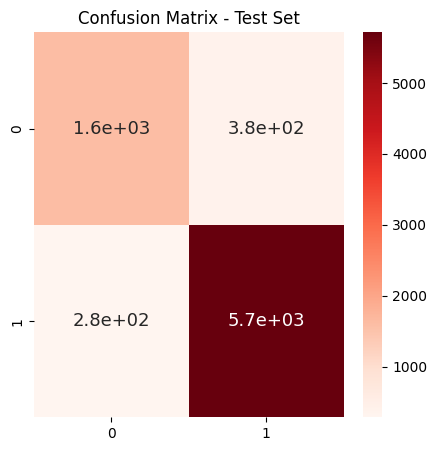

In [ ]:
loaded_model_two_classes = load_model(file_path)
_, _, _, = metrics_report(loaded_model_two_classes, X_test, y_test, split = "Test", size = (5,5), verbose = True)

Con questo tipo di problema, avendo 1/4 delle classi di prima, raggiungiamo le stesse prestazioni in circa 1/4 delle epoche, risparmiando tempo e risorse.